In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html

import plotly.graph_objects as go

import numpy as np
import datetime as dt
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

# Input data for excess mortality

* raw data 2020 from: https://appsso.eurostat.ec.europa.eu/nui/submitViewTableAction.do
* older data 
* data aggregated by https://www.mortality.org
* documentation [here](https://www.mortality.org/Public/STMF_DOC/STMFmetadata.pdf)

### Info website:

In response to the COVID-19 pandemic, the HMD team decided to establish a new data resource: Short-term Mortality Fluctuations (STMF) data series. Objective and internationally comparable data are crucial to determine the effectiveness of different strategies used to address epidemics. Weekly death counts provide the most objective and comparable way of assessing the scale of short-term mortality elevations across countries and time. Here we provide weekly death counts for **13 countries: Austria, Denmark, Belgium, England and Wales, Finland, Germany, Iceland, Netherlands, Norway, Portugal, Spain, Sweden, and the USA.** The same data in the pooled CSV file are available for download here. Data formats and methods are described in the STMFNote. We also strongly recommend reading the metadata text. Following the HMD practice, we also publish original input data in standardized format. During the next few weeks data will be frequently updated and new countries will be added. **The most recent STMF update is: 2020-05-24.**

In [2]:
path = Path('data/mortality_org.csv')

df = pd.read_csv(path, skiprows=1)

In [3]:
df['CountryCode'].value_counts()

FIN        4734
NLD        3948
BEL        3177
ESP        3177
NOR        3171
AUT        3162
DNK        2079
SWE        1614
GBRTENW    1614
USA        1143
PRT         990
DEUTNP      672
ISL         513
Name: CountryCode, dtype: int64

In [4]:
mask_gender_all = df['Sex'] == 'b'
mask_belgium = df['CountryCode'] == 'BEL'
cols = ['CountryCode', 'Year', 'Week', 'DTotal']

In [5]:
df_bel = pd.DataFrame(df[mask_belgium & mask_gender_all][cols])

In [6]:
year_min = df_bel['Year'].min()
year_max = df_bel['Year'].max()

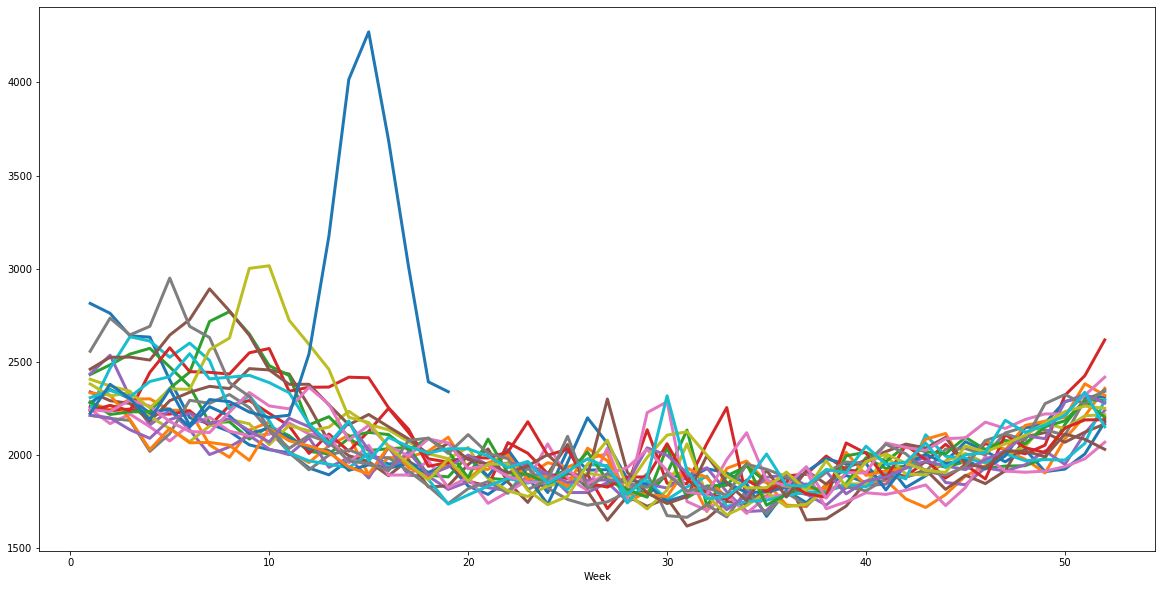

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

for year in range(year_min, year_max+1):
    new_colname = str(year)+'death_counts'
    year_mask = df_bel['Year'] == year
    df_bel1 = df_bel.rename(columns={'DTotal': new_colname})
    
    df_bel1[year_mask].plot(x='Week', y=new_colname, ax=ax, linewidth=3, legend=None)
    
    



### IDEAS

* This one would be nice as an animation. Draw one year at a time, 
* add confidence boundaries, 
* make it opaque after it has finished, 
* dropdown to select a different country
* hover with the week=> date
* na over komt er dan ondersterfte? => check met griep pieken laatste jaren
* on hover hulplijnen naar assen zetten
* extra pieken annoteren (hittegolven)
* oversterfte % eventueel als een bar chart met cijfertjes in onderaan?

In [8]:
df_bel

CountryCode  Year  Week  DTotal
3164         BEL  2000     1  2814.0
3167         BEL  2000     2  2761.0
3170         BEL  2000     3  2640.0
3173         BEL  2000     4  2633.0
3176         BEL  2000     5  2403.0
...          ...   ...   ...     ...
6326         BEL  2020    15  4271.0
6329         BEL  2020    16  3689.0
6332         BEL  2020    17  3014.0
6335         BEL  2020    18  2393.0
6338         BEL  2020    19  2340.0

[1059 rows x 4 columns]

# 2. In between countries

* population sizes: https://en.wikipedia.org/wiki/List_of_countries_by_population_%28United_Nations%29

In [9]:
#param country

country = 'BEL'
df
million_inhab = 12


def generate_excess_df(country, df, million_inhab):

    ####
    mask_gender_all = df['Sex'] == 'b'
    mask_country = df['CountryCode'] == country
    cols = ['CountryCode', 'Year', 'Week', 'DTotal']
    df_country = pd.DataFrame(df[mask_country & mask_gender_all][cols])


    #calculate avg death

    df_gr = df_country.groupby('Week').aggregate({'DTotal': np.median}).rename(columns={'DTotal': 'avg_death'})

    df_country_joined = (
        df_country
            .set_index('Week')
            .join(df_gr)
    )

    df_country_joined['excess_mortality'] = df_country_joined['DTotal'] - df_country_joined['avg_death']
    df_country_joined['excess_mortality_mil'] = df_country_joined['excess_mortality']/million_inhab

    mask = df_country_joined['Year'] == 2020
    df_now = pd.DataFrame(
        df_country_joined[mask])

    return df_now[['excess_mortality_mil']].rename(columns={'excess_mortality_mil': country+'_exmomi'})


In [10]:
generate_excess_df('USA', df, million_inhab)



USA_exmomi
Week             
1        4.875000
2      -44.375000
3      -38.833333
4      -15.791667
5       -6.125000
6        8.833333
7       13.958333
8       12.541667
9       34.458333
10      -3.166667
11     -89.000000
12     -54.041667
13     229.000000
14     766.083333
15     945.666667
16     -36.250000
17   -2249.541667

In [11]:
all_countries = df['CountryCode'].value_counts().keys().values

In [12]:
all_countries

array(['FIN', 'NLD', 'BEL', 'ESP', 'NOR', 'AUT', 'DNK', 'SWE', 'GBRTENW',
       'USA', 'PRT', 'DEUTNP', 'ISL'], dtype=object)

In [13]:
all_inhab = [5.532, 17.060, 46.737, 11.539, 5.379, 8.955, 5.772, 67.530, 10.036, 329.065, 10.226, 83.517, 0.339]
all_inhab[1]

17.06

In [14]:
dfs = []

for country, inhab in zip(all_countries,all_inhab):
    dfs.append(generate_excess_df(country, df, inhab))

In [15]:
df_exmomi = pd.concat(dfs, axis=1)

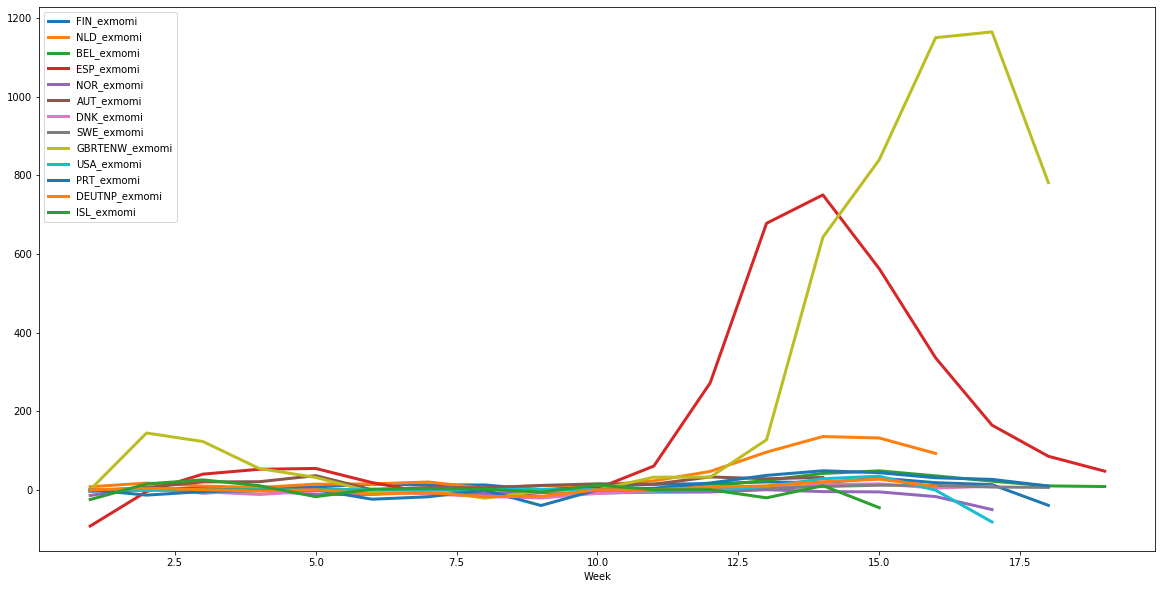

In [16]:
df_exmomi.plot(legend=1, figsize=(20,10), linewidth=3)

In [17]:
df_exmomi.max()

FIN_exmomi          29.645698
NLD_exmomi         135.316530
BEL_exmomi          48.056144
ESP_exmomi         750.151660
NOR_exmomi           7.622235
AUT_exmomi          35.845896
DNK_exmomi          14.899515
SWE_exmomi          11.431956
GBRTENW_exmomi    1164.906337
USA_exmomi          34.485588
PRT_exmomi          48.210444
DEUTNP_exmomi       26.844834
ISL_exmomi          25.073746
dtype: float64

In [18]:
df_exmomi.cumsum().plot(legend=1, figsize=(20,10), linewidth=3)

# 3 Small countries - medium - big countries same dynamics?

No clear pattern

In [19]:
filename = 'data/owid-covid-data.csv'

In [20]:
df = pd.read_csv(filename)

In [21]:
df.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k'],
      dtype='object')

In [22]:
df['location'].value_counts()

Germany           148
Israel            148
Mexico            148
China             148
Austria           148
                 ... 
Yemen              47
Western Sahara     31
Tajikistan         26
Comoros            25
Lesotho            12
Name: location, Length: 212, dtype: int64

In [23]:
df['population'].describe()

count    1.985400e+04
mean     1.084762e+08
std      6.887964e+08
min      8.090000e+02
25%      2.225728e+06
50%      9.660350e+06
75%      3.691056e+07
max      7.794799e+09
Name: population, dtype: float64

### deaths vs population size => niet echt een effect, san marino en paar andere mini's

In [24]:
agg_dict = {
    
    'total_deaths': np.max,
    'population':   np.max,
    'population_density': np.max,
    'gdp_per_capita': np.max,
    'diabetes_prevalence': np.max,
    'hospital_beds_per_100k': np.max

}


df_current_covid_total_deaths_t = df.groupby(['location']).aggregate(agg_dict)

df_current_covid_total_deaths = df_current_covid_total_deaths_t.drop('World', axis=0)

df_current_covid_total_deaths['deaths_scaled'] = df_current_covid_total_deaths['total_deaths'] / df_current_covid_total_deaths['population'] *1e6

In [25]:
df_current_covid_total_deaths.sort_values('total_deaths', ascending=False)

total_deaths   population  \
location                                                      
United States                            98220  331002647.0   
United Kingdom                           36914   67886004.0   
Italy                                    32877   60461828.0   
Spain                                    28752   46754783.0   
France                                   28432   65273512.0   
...                                        ...          ...   
Saint Kitts and Nevis                        0      53192.0   
Saint Lucia                                  0     183629.0   
Bonaire Sint Eustatius and Saba              0      26221.0   
Seychelles                                   0      98340.0   
Saint Vincent and the Grenadines             0     110947.0   

                                  population_density  gdp_per_capita  \
location                                                               
United States                                 35.608       54225.446   
United Kingdom                               272.898       39753.244   
Italy                                        205.859       35220.084   
Spain                                         93.105       34272.360   
France                                       122.578       38605.671   
...                                              ...             ...   
Saint Kitts and Nevis                        212.865       24654.385   
Saint Lucia                                  293.187       12951.839   
Bonaire Sint Eustatius and Saba                  NaN             NaN   
Seychelles                                   208.354       26382.287   
Saint Vincent and the Grenadines             281.787       10727.146   

                                  diabetes_prevalence  hospital_beds_per_100k  \
location                                                                        
United States                                   10.79                    2.77   
United Kingdom                                   4.28                    2.54   
Italy                                            4.78                    3.18   
Spain                                            7.17                    2.97   
France                                           4.77                    5.98   
...                                               ...                     ...   
Saint Kitts and Nevis                           12.84                    2.30   
Saint Lucia                                     11.62                    1.30   
Bonaire Sint Eustatius and Saba                   NaN                     NaN   
Seychelles                                      10.55                    3.60   
Saint Vincent and the Grenadines                11.62                    2.60   

                                  deaths_scaled  
location                                         
United States                        296.734787  
United Kingdom                       543.764514  
Italy                                543.764572  
Spain                                614.953127  
France                               435.582507  
...                                         ...  
Saint Kitts and Nevis                  0.000000  
Saint Lucia                            0.000000  
Bonaire Sint Eustatius and Saba        0.000000  
Seychelles                             0.000000  
Saint Vincent and the Grenadines       0.000000  

[211 rows x 7 columns]

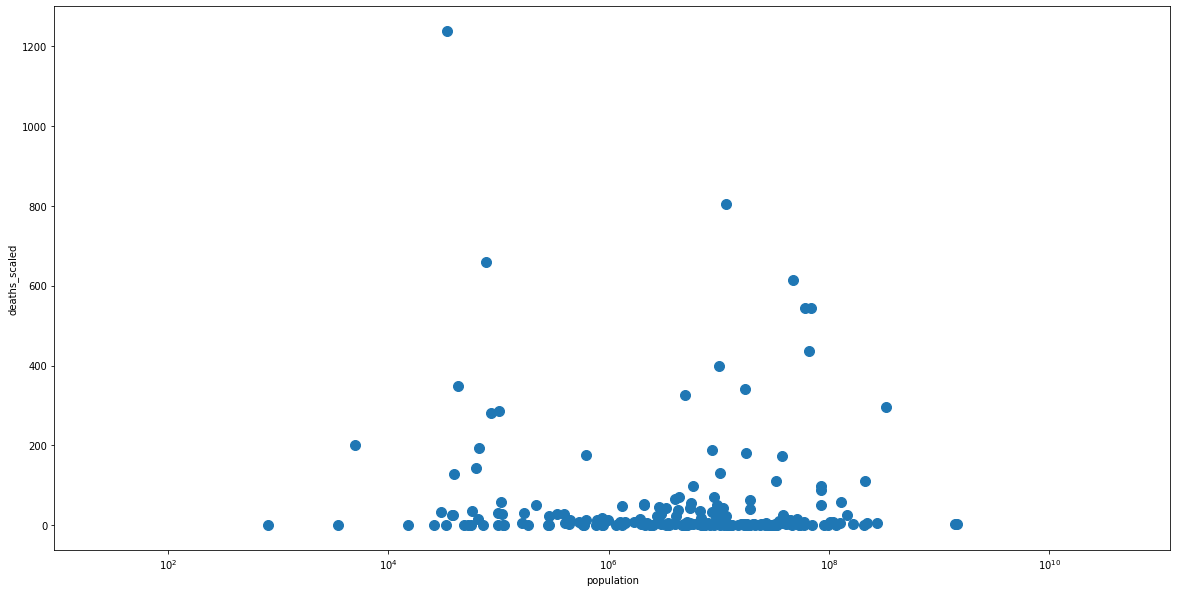

In [26]:
df_current_covid_total_deaths.plot(kind='scatter', x='population', 
                                   y='deaths_scaled', logx=True, s=100,
                                  figsize=(20,10))

In [27]:
df_current_covid_total_deaths.sort_values('deaths_scaled', ascending=False)

total_deaths  population  population_density  \
location                                                         
San Marino                  42     33938.0             556.667   
Belgium                   9312  11589616.0             375.564   
Andorra                     51     77265.0             163.755   
Spain                    28752  46754783.0              93.105   
Italy                    32877  60461828.0             205.859   
...                        ...         ...                 ...   
Greenland                    0     56772.0               0.137   
Cambodia                     0  16718971.0              90.672   
Gibraltar                    0     33691.0            3457.100   
French Polynesia             0    280904.0              77.324   
International                7         NaN                 NaN   

                  gdp_per_capita  diabetes_prevalence  hospital_beds_per_100k  \
location                                                                        
San Marino             56861.470                 5.64                    3.80   
Belgium                42658.576                 4.29                    5.64   
Andorra                      NaN                 7.97                     NaN   
Spain                  34272.360                 7.17                    2.97   
Italy                  35220.084                 4.78                    3.18   
...                          ...                  ...                     ...   
Greenland                    NaN                 2.16                     NaN   
Cambodia                3645.070                 4.00                    0.80   
Gibraltar                    NaN                  NaN                     NaN   
French Polynesia             NaN                22.63                     NaN   
International                NaN                  NaN                     NaN   

                  deaths_scaled  
location                         
San Marino          1237.550828  
Belgium              803.477872  
Andorra              660.066007  
Spain                614.953127  
Italy                543.764572  
...                         ...  
Greenland              0.000000  
Cambodia               0.000000  
Gibraltar              0.000000  
French Polynesia       0.000000  
International               NaN  

[211 rows x 7 columns]

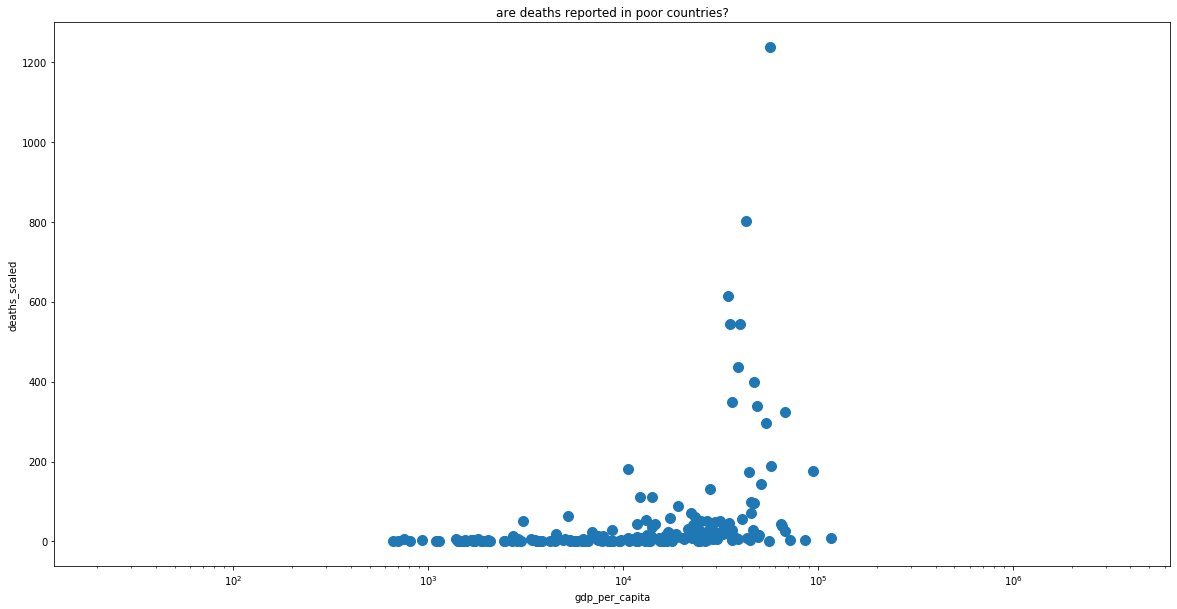

In [28]:
df_current_covid_total_deaths.plot(kind='scatter', x='gdp_per_capita', 
                                   y='deaths_scaled', logx=True, s=100,
                                  figsize=(20,10), title='are deaths reported in poor countries?')

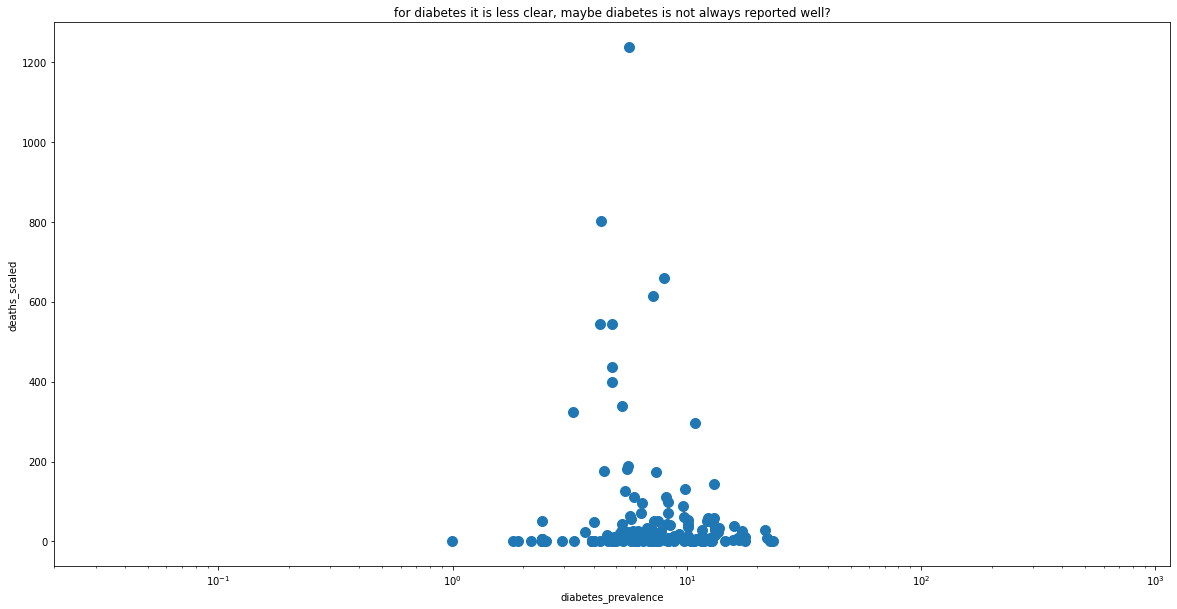

In [29]:
df_current_covid_total_deaths.plot(kind='scatter', x='diabetes_prevalence', 
                                   y='deaths_scaled', logx=True, s=100,
                                  figsize=(20,10), title='for diabetes it is less clear, maybe diabetes is not always reported well?')

In [30]:
df_current_covid_total_deaths.plot(kind='scatter', x='hospital_beds_per_100k', 
                                   y='deaths_scaled', logx=True, s=25 + df_current_covid_total_deaths['population']/1e6,
                                  figsize=(20,10), title='Beds are no magic solution...')

# 4. Speed of epidemic new versus total cases

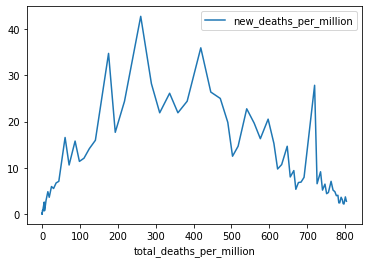

In [31]:
interesting_cols = ['location', 'date', 'total_deaths_per_million', 'new_deaths_per_million']
mask = df['location'] == 'Belgium'

df_be = pd.DataFrame(df[mask][interesting_cols])


df_be.plot(kind='line', x='total_deaths_per_million', y='new_deaths_per_million')

In [32]:
df.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k'],
      dtype='object')

In [33]:
df_be['new_deaths_per_million_7d'] = df_be['new_deaths_per_million'].rolling(window=7).mean()

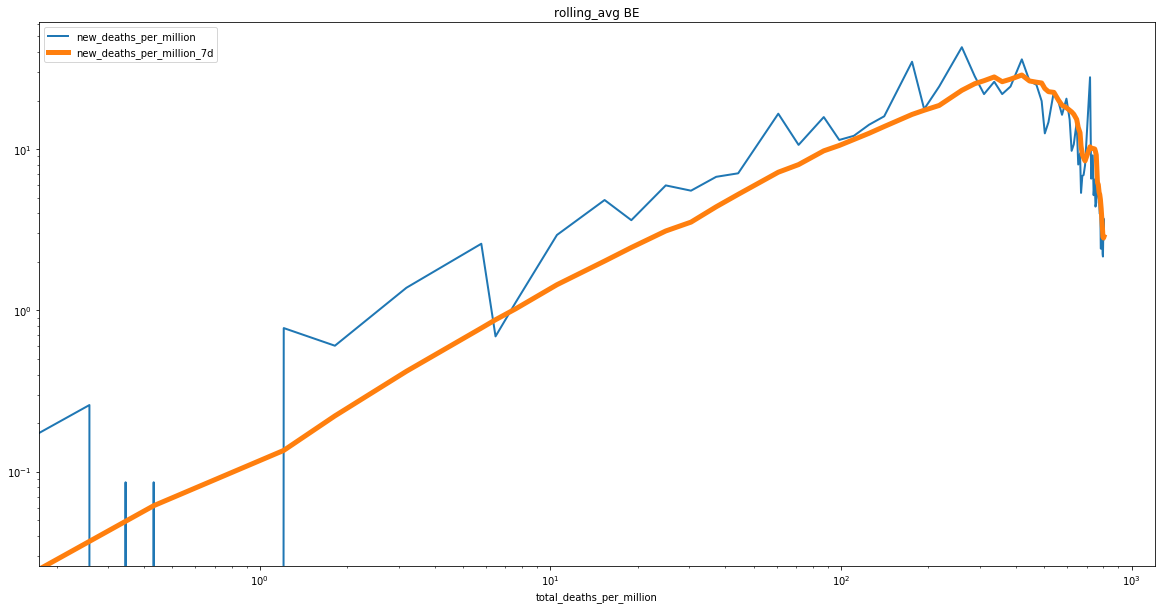

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

df_be.plot(kind='line', loglog=True, title='rolling_avg BE', x='total_deaths_per_million', y='new_deaths_per_million', linewidth=2, ax=ax)

df_be.plot(kind='line', x='total_deaths_per_million', y='new_deaths_per_million_7d', linewidth=5, ax=ax)


In [35]:
df_be['new_deaths_per_million_7d']

1406         NaN
1407         NaN
1408         NaN
1409         NaN
1410         NaN
          ...   
1549    3.488286
1550    3.118429
1551    2.859571
1552    2.810286
1553    2.859571
Name: new_deaths_per_million_7d, Length: 148, dtype: float64

In [36]:
def generate_multiplicator_df(country, df, window):
    interesting_cols = ['location', 'date', 'total_deaths_per_million', 'new_deaths_per_million']
    mask = df['location'] == country
    df_c = pd.DataFrame(df[mask][interesting_cols])

    df_c[country] = df_c['new_deaths_per_million'].rolling(window=window).mean()
    
    return df_c

In [37]:
df_be = generate_multiplicator_df('Belgium', df, 7)

In [38]:
df_be.plot(kind='line', x='total_deaths_per_million', y='Belgium', linewidth=5, loglog=True)


In [39]:
#doubling every four days
fraction_new = np.power(2, 1/4) - 1 

In [40]:
df_be['4d_doubling'] = df_be['total_deaths_per_million']*fraction_new

In [41]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

def plot_countries_doubling(ax, countries):
    
    df_be = generate_multiplicator_df('Belgium', df, 7)
    df_be['Belgium'] =  df_be['Belgium'] *0.5 #tryout for overreporting
    fraction_new = np.power(2, 1/4) - 1 
    df_be['4d_doubling'] = df_be['total_deaths_per_million']*fraction_new
    
    #fraction_new = np.power(2, 1/100) - 1 
    #df_be['100d_doubling'] = df_be['total_deaths_per_million']*fraction_new
    
    #fraction_new = np.power(2, 1/365) - 1 
    #df_be['yearly_doubling'] = df_be['total_deaths_per_million']*fraction_new
    
    df_be.plot(kind='line', x='total_deaths_per_million', y='Belgium', linewidth=5, loglog=True, ax=ax)
    df_be.plot(kind='line', x='total_deaths_per_million', y='4d_doubling', linewidth=5, loglog=True, ax=ax)
    #df_be.plot(kind='line', x='total_deaths_per_million', y='100d_doubling', linewidth=5, loglog=True, ax=ax)
    #df_be.plot(kind='line', x='total_deaths_per_million', y='yearly_doubling', linewidth=5, loglog=True, ax=ax)

    
    for c in countries:
        df_c = generate_multiplicator_df(c, df, 7)
        df_c.plot(kind='line', x='total_deaths_per_million', y=c, linewidth=5, loglog=True, ax=ax, grid='on')


countries = ["Finland", "Netherlands", "Spain", "Norway", "Austria", "Denmark", "Sweden", 
             "United Kingdom", "United States", "Portugal", "Germany", "Iceland"]
    
countries_mini = ["Netherlands", "Spain", "Sweden", 
             "United Kingdom", "United States", "Germany", "Singapore", "Brazil"]     

plot_countries_doubling(ax, countries_mini )

In [42]:
df['location'].value_counts().loc['Norway']

148